Loading model and scaler...
Success.
Loading data...
 -> Loaded: Wort 0
 -> Loaded: Wort 300
Generating predictions...
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- STATS FOR PRESENTATION ---

Group: Wort 0
  Mean:   -58.8 µg/L
  Median: -54.5 µg/L (Report this)
  Min:    -522.5 µg/L
  Max:    388.6 µg/L

Group: Wort 300
  Mean:   180.0 µg/L
  Median: 151.9 µg/L (Report this)
  Min:    -431.7 µg/L
  Max:    1562.0 µg/L


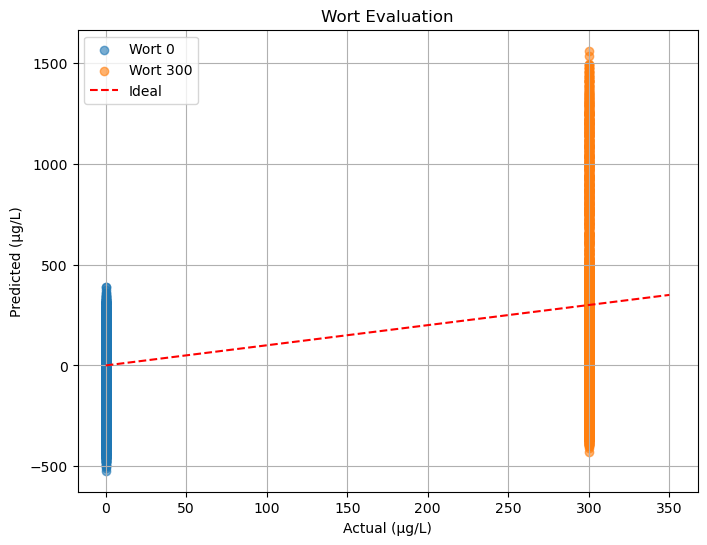

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\3940730260.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Predicted', data=plot_df, palette="muted")


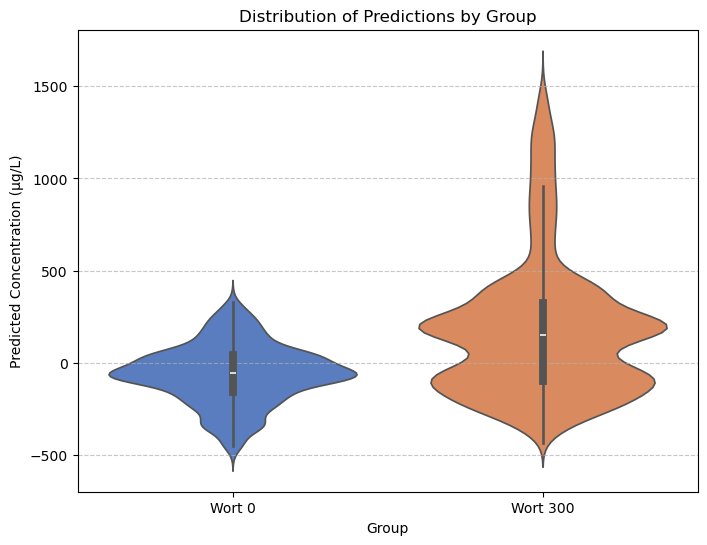


Done.


In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import joblib

# --- 1. LOAD SAVED MODEL AND SCALER ---
MODEL_NAME = 'dms_model_0_900.keras'
SCALER_NAME = 'dms_scaler_0_900.pkl'

print(f"Loading model and scaler...")
try:
    scaler = joblib.load(SCALER_NAME)
    model = tf.keras.models.load_model(MODEL_NAME)
    print("Success.")
except IOError:
    print(f"Error: Files not found.")
    exit()

# --- 2. LOAD NEW DATA (Fixed Strategy) ---
base_dir = r"C:\Users\DELL\OneDrive\Documents\Smart Brewery\Measurements\Measurements 07.11.2025"

# Use a list of dictionaries to define files and labels explicitly
files_config = [
    {
        "path": os.path.join(base_dir, "Wort 0_DMS.csv"),
        "target": 0,
        "label": "Wort 0"
    },
    {
        "path": os.path.join(base_dir, "Wort 300_mcg_L DMS.csv"),
        "target": 300,
        "label": "Wort 300"
    }
    # Add more files here if needed, e.g.:
    # {"path": os.path.join(base_dir, "Water_300.csv"), "target": 300, "label": "Water 300"}
]

dataframes = []
print("Loading data...")

for item in files_config:
    if os.path.exists(item["path"]):
        df = pd.read_csv(item["path"])
        df["target"] = item["target"]      # Numeric target for metrics
        df["Group"] = item["label"]        # String label for plotting
        dataframes.append(df)
        print(f" -> Loaded: {item['label']}")
    else:
        print(f" -> WARNING: File not found: {item['path']}")

if not dataframes:
    exit("No data loaded.")

test_data = pd.concat(dataframes, ignore_index=True)

# --- 3. PRE-PROCESS ---
features = [
    'heatProfile', 'waitTime', 'temp', 'humidity', 'pressure', 
    'gasResistance', 'gasValid', 'heaterStable', 'gasResistanceZScore'
]

X_new_scaled = scaler.transform(test_data[features].values)
y_actual = test_data["target"]

# --- 4. PREDICT ---
print("Generating predictions...")
y_pred = model.predict(X_new_scaled).flatten()

# --- 5. PREPARE RESULTS ---
plot_df = pd.DataFrame({
    'Actual': y_actual,
    'Predicted': y_pred,
    'Group': test_data["Group"]
})

# --- 6. STATISTICS ---
print("\n--- STATS FOR PRESENTATION ---")
for group in plot_df['Group'].unique():
    subset = plot_df[plot_df['Group'] == group]['Predicted']
    print(f"\nGroup: {group}")
    print(f"  Mean:   {subset.mean():.1f} µg/L")
    print(f"  Median: {subset.median():.1f} µg/L (Report this)")
    print(f"  Min:    {subset.min():.1f} µg/L")
    print(f"  Max:    {subset.max():.1f} µg/L")

# --- 7. PLOTTING ---

# Plot 1: Scatter
plt.figure(figsize=(8, 6))
for group in plot_df['Group'].unique():
    subset = plot_df[plot_df['Group'] == group]
    plt.scatter(subset['Actual'], subset['Predicted'], label=group, alpha=0.6)

plt.plot([0, 350], [0, 350], 'r--', label='Ideal')
plt.title('Wort Evaluation')
plt.xlabel("Actual (µg/L)")
plt.ylabel("Predicted (µg/L)")
plt.legend()
plt.grid(True)
plt.savefig('wort_scatter.png')
plt.show()

# Plot 2: Violin Plot (Best for comparison)
plt.figure(figsize=(8, 6))
sns.violinplot(x='Group', y='Predicted', data=plot_df, palette="muted")
plt.title('Distribution of Predictions by Group')
plt.ylabel("Predicted Concentration (µg/L)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('wort_violin.png')
plt.show()

print("\nDone.")